In [ ]:
# 필수 라이브러리 설치
!pip install pycocotools
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# 압축 해제
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip


--2024-12-17 10:32:59--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.129.193, 3.5.22.12, 3.5.24.150, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.129.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip.1’

train2017.zip.1     100%[===================>]  18.01G   115MB/s    in 3m 33s  

2024-12-17 10:36:33 (86.4 MB/s) - ‘train2017.zip.1’ saved [19336861798/19336861798]

--2024-12-17 10:36:33--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.32.217, 54.231.232.9, 3.5.25.246, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.32.217|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotatio

데이터 로드 및 전처리

loading annotations into memory...
Done (t=30.24s)
creating index...
index created!
COCO 카테고리 수: 80


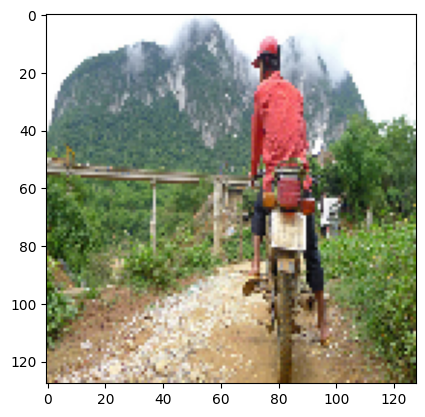

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

# COCO 어노테이션 로드
annotation_file = 'annotations/instances_train2017.json'
coco = COCO(annotation_file)

# 카테고리 ID 로드
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)
print("COCO 카테고리 수:", len(categories))

# 이미지 로드 및 바운딩 박스 전처리 함수
def load_image_with_boxes(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"train2017/{img_info['file_name']}"
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))

    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)
    boxes = []
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        boxes.append([x, y, x+w, y+h])

    return image, np.array(boxes)


img_id = coco.getImgIds()[0]
image, boxes = load_image_with_boxes(img_id)

plt.imshow(image)
for box in boxes:
    x1, y1, x2, y2 = box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
plt.show()


모델 설계

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape

# 모델 구조 정의
input_layer = Input(shape=(128, 128, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)

# 바운딩 박스 좌표 출력
output_layer = Dense(4, activation='linear')(x)  # (x_min, y_min, x_max, y_max)

# 모델 생성 및 컴파일
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │       2,097,156 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,102,244 (8.02 MB)

 Trainable params: 2,102,244 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

데이터셋 생성 및 모델 훈련

In [ ]:
def create_dataset(num_samples=1000):
    images = []
    boxes = []
    img_ids = coco.getImgIds()

    for i in range(num_samples):
        img_id = img_ids[i]
        image, box = load_image_with_boxes(img_id)

        # 바운딩 박스가 비어있거나 없는 경우 건너뛰기
        if box is None or len(box) == 0:
            print(f"Image ID {img_id} has no bounding boxes. Skipping...")
            continue

        images.append(image / 255.0)  # 정규화
        boxes.append(box[0])  # 첫 번째 바운딩 박스만 사용

    if not images or not boxes:
        raise ValueError("No valid data was found. Check your dataset!")

    return np.array(images), np.array(boxes)

# 데이터셋 로드
try:
    X_train, y_train = create_dataset(num_samples=1000)
    print(f"Dataset created successfully! Images: {X_train.shape}, Boxes: {y_train.shape}")
except ValueError as e:
    print(e)

# 모델 훈련
if len(X_train) > 0 and len(y_train) > 0:
    model.fit(X_train, y_train, epochs=10, batch_size=32)
else:
    print("No valid data available for training.")


Image ID 262284 has no bounding boxes. Skipping...
Image ID 108169 has no bounding boxes. Skipping...
Image ID 176649 has no bounding boxes. Skipping...
Image ID 570045 has no bounding boxes. Skipping...
Image ID 191501 has no bounding boxes. Skipping...
Image ID 125997 has no bounding boxes. Skipping...
Image ID 69911 has no bounding boxes. Skipping...
Image ID 375363 has no bounding boxes. Skipping...
Image ID 325690 has no bounding boxes. Skipping...
Image ID 75083 has no bounding boxes. Skipping...
Image ID 26767 has no bounding boxes. Skipping...
Image ID 336777 has no bounding boxes. Skipping...
Image ID 217005 has no bounding boxes. Skipping...
Dataset created successfully! Images: (987, 128, 128, 3), Boxes: (987, 4)
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 895ms/step - loss: 51665.9102
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 21828.1680
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 929ms/step - loss: 19371.2461
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - l

훈련된 모델 사용 및 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


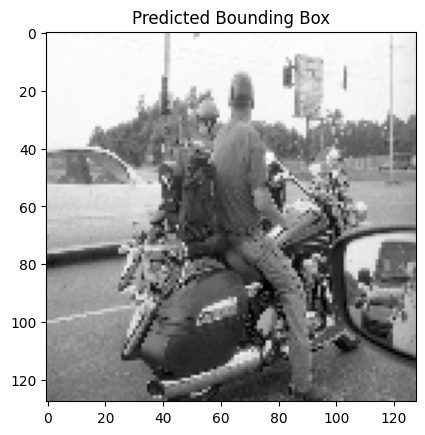

In [ ]:
# 테스트 이미지 예측
test_img_id = coco.getImgIds()[100]
test_image, test_boxes = load_image_with_boxes(test_img_id)
test_image_input = np.expand_dims(test_image / 255.0, axis=0)

# 예측 수행
predicted_box = model.predict(test_image_input)[0]

# 시각화
plt.imshow(test_image)
plt.gca().add_patch(plt.Rectangle((predicted_box[0], predicted_box[1]),
                                  predicted_box[2] - predicted_box[0],
                                  predicted_box[3] - predicted_box[1],
                                  fill=False, edgecolor='blue', linewidth=2))
plt.title("Predicted Bounding Box")
plt.show()
